In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Web scraping
import requests
import re
from bs4 import BeautifulSoup 

import gc;

In [28]:
gc.collect()

52

# Loading Datasets

In [2]:
def load_raw_outputs():
  outputs_cname = [
                "txID", 
                "position", 
                "addressID",
                "amount",
                "scriptType"
              ]

  outputs_dtype_spec = {
    outputs_cname[0]: "uint32",   
    outputs_cname[1]: "uint32",
    outputs_cname[2]: "uint32",
    outputs_cname[3]: "uint32",
    outputs_cname[4]: "uint8",
  }

  outputs = pd.read_csv("data/outputs.csv", 
                        # usecols=[0, 2, 4],
                        header=None, 
                        names=outputs_cname, 
                        dtype=outputs_dtype_spec,
                        index_col=[outputs_cname[0], outputs_cname[1]], #txID, position
                        engine='c'
                    )
  
  return outputs

def load_raw_inputs():
  inputs_cname = ["txID", 
              "prevTxID", 
              "prevTxPos"
              ]

  inputs_dtype_spec = {
      inputs_cname[0]: "uint32",   
      inputs_cname[1]: "uint32",
      inputs_cname[2]: "uint32",
  }

  inputs = pd.read_csv("data/inputs.csv", 
                          # usecols=[0],
                          header=None, 
                          names=inputs_cname, 
                          dtype=inputs_dtype_spec,
                          index_col=[inputs_cname[1], inputs_cname[2]], #prevTx, prevTxPos
                          engine='c'
                      )

  return inputs

def load_raw_transactions():
  trans_cname = ["timestamp", "blockID", "txID", "isCoinbase", "fee"]
  trans_dtype_spec = {
      "timestamp": "uint32",   
      "blockID": "uint32",
      "txID": "uint32",
      "isCoinbase": "bool",
      "fee": "uint32"
  }

  transactions = pd.read_csv("data/transactions.csv",
                                # usecols=[0, 2, 3, 4],
                                header=None, 
                                names=trans_cname, 
                                dtype=trans_dtype_spec,
                                index_col=trans_cname[2], #txID
                                engine='c'
                            )

  return transactions


def load_raw_addresses():
  addr_map_cname = [
                      "address", 
                      "addressID", 
                  ]

  addr_map_dtype_spec = {
      addr_map_cname[0]: "string",   
      addr_map_cname[1]: "int32",
  }

  addr_map = pd.read_csv("data/mapAddr2Ids.csv", 
                          # usecols=[0, 4],
                          header=None, 
                          names=addr_map_cname, 
                          dtype=addr_map_dtype_spec,
                          index_col=addr_map_cname[1],
                          engine='c'
                      )
  return addr_map

In [3]:
outputs = load_raw_outputs()
inputs = load_raw_inputs()
transactions = load_raw_transactions()
addresses = load_raw_addresses()

## Dataset test

Testing Foreign keys & Fields values

In [4]:
assert len(transactions[transactions['blockID'] < 0]) == 0, "Errore: transazioni con block_id negativo"

In [5]:
assert len(outputs[outputs.index.get_level_values('txID').isin(transactions.index)]) == len(outputs), "Errore: output che fanno riferimento ad un tx_id non contenuto in nessun blocco"

In [6]:
assert len(inputs[inputs['txID'].isin(transactions.index)]) == len(inputs), "Errore: input che fanno riferimento ad un tx_id non contenuto in nessun blocco"

Testing indexes uniqness

In [ ]:
transactions.index.is_unique

In [ ]:
inputs.index.is_unique

In [ ]:
outputs.index.is_unique

It seams that is present some strange duplicate values... 

In [7]:
g_outs = outputs[['addressID']].groupby(level=["txID", "position"]).count()
g_outs = g_outs[g_outs['addressID'] > 1].rename(columns={
    'addressID': 'count' 
}).reset_index()

dup_out = outputs[outputs.index.get_level_values("txID").isin(g_outs['txID'])].sort_values(by="txID")
dup_out

addressID     amount  scriptType
txID   position                                  
142572 0            141029  705032704           1
       0            141029  705032704           1
142726 0            141187  705032704           1
       0            141187  705032704           1

In [8]:
g_tx = transactions[['blockID']].groupby(level=["txID"]).count()
g_tx = g_tx[g_tx['blockID'] > 1].rename(columns={
    'blockID': 'count' 
}).reset_index()

dup_tx = transactions[transactions.index.isin(g_tx['txID'])].sort_values(by='txID')
dup_tx

,timestamp,blockID,isCoinbase,fee
txID,,,,
142572,1289723848,91722,True,0
142572,1289781379,91880,True,0
142726,1289757588,91812,True,0
142726,1289768691,91842,True,0


There are duplicate tx with txID (142572, 142726) and duplicate outputs for same transactions...

We can see that duplicate transactions are coinbase ones and are assigned in different block IDs

Let's ensure that all blocks **have extaclty one coinbase transaction**...

In [9]:
conbaise_block = transactions[transactions['isCoinbase']][['blockID']].reset_index().groupby(['blockID']).count()
assert len(conbaise_block[conbaise_block['txID'] > 1]) == 0, "Error: more then one coinbase tx in a block"
assert len(conbaise_block[conbaise_block['txID'] == 0]) == 0, "Error: txs without coinbase output"

We can see that is the case. 1 Block <=> 1 Coinbase tx, so it's not probably a duplicate insertion error when creating the dataset but just a **naming error**

We have to distingiush between the transactions of different blocks. Fortunately we can see the transactions with same ID have outputs with same amount so we can safly rename one of the two transactions


Let's display txs wich are near duplicated ones timestamp's

In [10]:
invalid_enumerations = []

for i in range(len(dup_tx)):
    target_timestamp = dup_tx.iloc[i]['timestamp']
    tx_id = dup_tx.index[i]
    
    def highlight_zero_diff(row):
        global tx_id
        if row.name == tx_id:
            return ['background-color: yellow'] * len(row)
        else:
            return [''] * len(row)
    
    df = transactions[abs(transactions['timestamp'].astype(np.int32) - target_timestamp) < 2000]

    tx_index = df.index.get_loc(tx_id)
    assert tx_index - 2 > 0, "Error: adjust delta range to have some rows before target"
    assert tx_index + 3 < len(df), "Error: adjust delta range to have some rows after target"

    start_index = tx_index - 2
    end_index =  tx_index + 3

    valid_enum = df.iloc[tx_index-1].name < tx_id and df.iloc[tx_index+1].name > tx_id
    if not valid_enum: 
        invalid_enumerations.append((tx_id, df.iloc[tx_index]['blockID']))
    
    df_subset = df.iloc[start_index:end_index]
    df_subset = df_subset.style.apply(highlight_zero_diff, axis=1)
    
    # df = df.sort_values(by="delta").head()
    # df = df.style.apply(highlight_zero_diff, axis=1)

    display(df_subset)

,timestamp,blockID,isCoinbase,fee
txID,,,,
142570,1289723356,91720,False,0
142571,1289723346,91721,True,0
142572,1289723848,91722,True,0
142573,1289724123,91723,True,0
142574,1289724489,91724,True,0


,timestamp,blockID,isCoinbase,fee
txID,,,,
142838,1289779841,91879,False,0
142839,1289779841,91879,False,0
142572,1289781379,91880,True,0
142840,1289781379,91880,False,0
142841,1289782077,91881,True,0


,timestamp,blockID,isCoinbase,fee
txID,,,,
142724,1289757153,91810,False,0
142725,1289757226,91811,True,0
142726,1289757588,91812,True,0
142727,1289757588,91812,False,0
142728,1289757573,91813,True,0


,timestamp,blockID,isCoinbase,fee
txID,,,,
142781,1289768619,91841,True,0
142782,1289768619,91841,False,0
142726,1289768691,91842,True,0
142783,1289768875,91843,True,0
142784,1289769047,91844,True,0


In [11]:
invalid_enumerations

[(142572, 91880), (142726, 91842)]

We can clearly see that \[(142572, 91880), (142726, 91842)\], (txID, blockID) are out of place...

Let's check if there are holes in txID enumeration

In [12]:
txIDs = transactions.reset_index()['txID'].sort_values()

In [13]:
tx_id_min = txIDs.min()
tx_id_max = txIDs.max()

expected_number_of_rows = tx_id_min + tx_id_max + 1
n_dup_tx = (g_tx['count'] - 1).sum()


if expected_number_of_rows - len(txIDs) + n_dup_tx == 0:
    print("No holes in txID")
else: 
    print("holes in txID")

No holes in txID


As we can see there are no holes in txID enumeration, so we can add a new txIDs = max(txIDs) + dup_idx

In [14]:
tmp_tx_df = transactions.reset_index().set_index(["txID", "blockID"])

In [15]:
__tx_rename_locs = []

for i, idx in enumerate(invalid_enumerations):
    loc = tmp_tx_df.index.get_loc(idx)
    __tx_rename_locs.append(loc)

print(__tx_rename_locs)

[142841, 142783]


In [16]:
tmp_tx_df = tmp_tx_df.reset_index()

In [17]:
tx_id_col = tmp_tx_df.columns.get_loc('txID')
__tx_renaming_mapping = {}

for i, loc in enumerate(__tx_rename_locs):
    old_row = tmp_tx_df.iloc[loc]
    new_tx_id = tx_id_max + 1 + i
    __tx_renaming_mapping[old_row['txID']] = (new_tx_id)
    
    tmp_tx_df.iat[loc, tx_id_col] = new_tx_id

In [18]:
tmp_tx_df = tmp_tx_df.set_index(['txID'])
assert tmp_tx_df.index.is_unique, "Error: something went wrong renaming transactions ids"

In [19]:
__tx_renaming_mapping

{142572: 10572827, 142726: 10572828}

In [20]:
transactions = tmp_tx_df

Now that we have adjusted transactions let's adjust outputs:
1) assert that all ambigous outputs have same amount script type & addressID
2) swap all ids in __tx_renaming_mapping

In [21]:
out_tmp = outputs.reset_index()

In [22]:
dup_out_uncount = dup_out.groupby(level=['txID', 'position']).nunique()
assert len(dup_out_uncount[(dup_out_uncount['addressID'] > 1) & (dup_out_uncount['amount'] > 1) & (dup_out_uncount['scriptType'] > 1)]) == 0, \
    "Error: cannot determinate renaming of ambigous outputs"

In [23]:
__out_rename_locs = []
for old_id in __tx_renaming_mapping.keys():
    loc_maks = outputs.index.get_loc(old_id)
    locs = out_tmp[loc_maks].index.tolist()
    __out_rename_locs.append((old_id, locs[0]))

print(__out_rename_locs)

[(142572, 172980), (142726, 173166)]


In [24]:
tx_id_col = out_tmp.columns.get_loc('txID')

for old_id, loc in __out_rename_locs: 
    newID = __tx_renaming_mapping[old_id]
    out_tmp.iat[loc, tx_id_col] = newID

In [25]:
out_tmp = out_tmp.set_index(['txID', 'position'])

In [26]:
assert out_tmp.index.is_unique, "Error: something went wrong renaming outputs ids"

In [27]:
outputs = out_tmp

# Analize

In [ ]:
INPUT_SIZE = 40
OUTPUT_SIZE = 9
SCRIPT_SIZE_MAPPING = {1: 153, 2: 180, 3: 291}

In [ ]:
nc_tx = transactions[~transactions['isCoinbase']]
nc_tx = nc_tx.copy()
nc_tx['timestamp'] = pd.to_datetime(nc_tx['timestamp'], unit='s')

In [ ]:
in_size = inputs.reset_index()[['txID']]
in_size['count'] = 0
in_size = in_size.groupby('txID').count()
in_size['count'] = in_size['count'] * INPUT_SIZE
in_size = in_size.rename(columns={'count': 'size'})

In [ ]:
assert len(in_size[in_size['size'].isna()]) == 0, "Error: found sone NaN inside in_size"

In [ ]:
out_size = outputs.reset_index()[['txID', 'scriptType']]
out_size['scriptType'] = out_size['scriptType'].map(SCRIPT_SIZE_MAPPING).fillna(0)
out_size['count'] = 1
out_size = out_size.groupby(['txID']).sum()

In [ ]:
out_size['size'] = out_size['scriptType'] + out_size['count'] * OUTPUT_SIZE
out_size = out_size[['size']]

In [ ]:
assert len(out_size[out_size['size'].isna()]) == 0, "Error: found sone NaN inside out_size"

In [ ]:
tx_sizes = in_size.join(out_size, lsuffix='_in', rsuffix='_out')

In [ ]:
tx_sizes = nc_tx.join(tx_sizes)

In [ ]:
tx_sizes['total_size'] = tx_sizes['size_in'] + tx_sizes['size_out']

In [ ]:
tx_sizes = tx_sizes[['timestamp', 'fee', 'total_size']]

In [ ]:
tx_sizes = tx_sizes.sort_values(by='total_size')

In [ ]:
tx_sizes['count'] = 1

In [ ]:
assert len(tx_sizes[tx_sizes['total_size'].isna()]) == 0, "Error: found sone NaN size inside tx_sizes"
assert len(tx_sizes[tx_sizes['fee'].isna()]) == 0, "Error: found sone NaN fee inside tx_sizes"

### Data distribution
Now that we have obtained the desired data frame to analize let's first plot some histograms to see data distribution

In [ ]:
plt.figure(figsize=(18, 6))
    
# Histogram for Congestion
plt.subplot(1, 2, 1)
plt.hist(tx_sizes['timestamp'], bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Histogram of transactions')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.hist(tx_sizes['timestamp'], bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Histogram of transactions(log)')
plt.yscale('log')
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 6))
    
# Histogram for sizes
plt.subplot(1, 2, 1)
plt.hist(tx_sizes['total_size'], bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Histogram of tx sizes')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.hist(tx_sizes['total_size'], bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Histogram of tx sizes (log)')
plt.yscale('log')
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 6))

# Histogram for fees
plt.subplot(1, 2, 1)
plt.hist(tx_sizes['fee'], bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Histogram of tx fee')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.hist(tx_sizes['fee'], bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Histogram of tx fee (log)')
plt.yscale('log')
plt.tight_layout()
plt.show()

### Grouping for time interval
Our data frame have information about txSize forach transaction, but wat we really want to show is congestion wich is the sum of tx_sizes in a time interval 

In [ ]:
time_bins = pd.Grouper(key='timestamp', freq='h')

time_grouped_size = tx_sizes.groupby(time_bins).agg({
    'fee': 'mean',
    'total_size': 'sum',
    'count': 'sum'
})

Let's filter out invalid groups

In [ ]:
time_grouped_size = time_grouped_size[~time_grouped_size['fee'].isna() & ~time_grouped_size['total_size'].isna()]

In [ ]:
time_grouped_size = time_grouped_size.sort_values(by="timestamp")
time_grouped_size = time_grouped_size.reset_index()

In [ ]:
#print(time_grouped_size.describe())
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(time_grouped_size['timestamp'], time_grouped_size['total_size'])


plt.subplot(1, 2, 2)
plt.plot(time_grouped_size['timestamp'], time_grouped_size['fee'])
plt.show()

We can see that congestion over time is related to the distribution of transactions

In [ ]:
time_grouped_size = time_grouped_size.sort_values(by="total_size")
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(time_grouped_size['total_size'], time_grouped_size['fee'])

## Script distribution over time

In [ ]:
tx_time = transactions[['timestamp', 'isCoinbase']]

In [ ]:
script_types = outputs.reset_index()[['txID', 'scriptType']].set_index('txID')

In [ ]:
script_types = script_types.join(tx_time)

In [ ]:
script_types['timestamp'] = pd.to_datetime(script_types['timestamp'], unit='s')

In [ ]:
def plot_type_over_time(grouped):
    def plot(df):
        for t in df.columns:
                plt.plot(df.index, df[t], label=f'Script Type {t}')
        
        plt.xlabel('Date')
        plt.ylabel('Usage %')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
    plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.title('Usage of Request Types Over Time')
    plot(grouped)
    
    filtered = grouped[[0, 3]]
    plt.subplot(1,2,2)
    
    plt.title('Usage of Script Types Over Time (type 0,3)')
    plot(filtered)

In [ ]:
usage_counts = script_types.groupby([pd.Grouper(key='timestamp', freq='2W'), 'scriptType']).size().unstack(fill_value=0)

In [ ]:
usage_percentages = usage_counts.div(usage_counts.sum(axis=1), axis=0) * 100

In [ ]:
plot_type_over_time(usage_percentages)

# Scraping

In [29]:
BASE_URL="http://www.walletexplorer.com"
KNOWN_WALLETS = ["DeepBit", "Eligius", "BTC Guild", "BitMinter"]
ADDR_MAP = {}

## Address deanonimization

In [36]:
CTX = transactions[transactions['isCoinbase']]

In [40]:
print(f"Coinbase transactions {len(CTX)}/{len(transactions)}")

Coinbase transactions 214563/10572829


In [31]:
COUT = outputs[outputs.index.get_level_values('txID').isin(CTX.index)]

In [44]:
print(f"Coinbase outputs {len(COUT)}/{len(outputs)}")

Coinbase outputs 508800/24613799


In [61]:
CADDR = addresses[addresses.index.isin(COUT['addressID'])].copy()

In [59]:
print(f"Coinbase outputs addr {len(CADDR)}/{len(addresses)}")

Coinbase outputs addr 202397/8708821


In [50]:
def get_page_number(soup, res): 
    paging_container = soup.find('div', class_='paging')
    if not paging_container:
        print(res)
    assert(paging_container)

    paging_text = paging_container.text.strip()
    match = re.search(r'Page (\d+) \/ (\d+)', paging_text)
    assert(match)
    
    total_pages = match.group(2)
    return int(total_pages)
    
def add_wallet_address(name, addrMap, sleep=1, page_number=1, curr_page=0):
    formatted_name = name.replace(" ", "")
    url = f"{BASE_URL}/wallet/{formatted_name}/addresses"
    print(f"Loading wallet: {url}")
    while curr_page < page_number: 
        curr_page += 1
        
        params = {'page': curr_page}
        response = requests.get(url, params=params)
        
        if response.url.split("?")[0] != url:
            url = response.url
            response = requests.get(url, params=params)

        soup = BeautifulSoup(response.content, 'html.parser')

        if curr_page == 1:
            page_number = get_page_number(soup, response)
        
        links = soup.find_all('a', href=lambda href: href and href.startswith('/address/'))    
        assert(links and len(links) > 0)
    
        for link in links: 
            addr = link['href'][9:]
            addrMap[addr]=name
            
        print(f"Found {len(links)} links for {name} page: {curr_page}/{page_number}")
        time.sleep(sleep)

def get_addr_wallet(addr):
    response = requests.get(f"{BASE_URL}/address/{addr}")
    soup = BeautifulSoup(response.content, 'html.parser')
   
    walletnote_div = soup.find('div', class_='walletnote')
    assert(walletnote_div)
    link = walletnote_div.find('a', href=lambda href: href and href.startswith('/wallet/'))    
    assert(link)
    link_url = link['href']
    wallet = link_url[8:]
    assert(len(wallet) > 0)
    
    return wallet

In [ ]:
for pool in KNOWN_WALLETS:
    add_wallet_address(pool, ADDR_MAP, 2)

In [76]:
CADDR['wallet'] = CADDR['address'].map(ADDR_MAP)

In [78]:
tx_per_addr = COUT.reset_index()[['amount', 'addressID']].groupby('addressID').count()
tx_per_addr = tx_per_addr.join(CADDR)
tx_per_addr = tx_per_addr[tx_per_addr['wallet'].isna()]
tx_per_addr = tx_per_addr.sort_values('amount', ascending=False)

In [ ]:
found_wallets = []
N_TOP = 4
i = 0

prev_len = len(ADDR_MAP)

while len(found_wallets) < min(N_TOP, len(tx_per_addr)):
    wallet = get_addr_wallet(tx_per_addr.iloc[i]['address'])
    if wallet in found_wallets:
        continue

    add_wallet_address(wallet, ADDR_MAP)
    found_wallets.append(wallet)
    i = i+1

assert len(found_wallets) == N_TOP, "Unexpeced error..."

print(f"Found {len(ADDR_MAP) - prev_len} new addresses")

In [98]:
CADDR['wallet'] = CADDR['address'].map(ADDR_MAP).fillna("Others")

In [83]:
not_anon_size = len(CADDR[~CADDR['wallet'].isna()])
size = len(CADDR)

print(f"Deanonimized {not_anon_size}/{size}")

Deanonimized 93/202397


In [99]:
CADDR.to_csv('data/deanonaddr.csv')

In [100]:
CADDR = pd.read_csv("data/deanonaddr.csv", index_col=['addressID'])

In [101]:
WALL_COUT = COUT.reset_index().set_index('addressID')[['amount', 'txID']].join(CADDR)
WALL_COUT = WALL_COUT.reset_index().set_index('txID').join(CTX[['timestamp']]).reset_index()
WALL_COUT['timestamp'] = pd.to_datetime(WALL_COUT['timestamp'], unit='s')

In [102]:
pool_blocks = WALL_COUT.groupby('wallet')[['wallet','txID', 'amount']].agg({
    'amount': 'sum',
    'txID': 'nunique'
}).sort_values('amount')

pool_blocks.columns = ['amount', 'nBlocks']

In [94]:
if pool_blocks['nBlocks'].sum() != transactions['blockID'].nunique():
    print("One block can reward multiple miners")

One block can reward multiple miners


,amount,nBlocks
wallet,,
Eligius,267687842979,1228
019a46b8d84bf5b5,1245314095202,1754
BitMinter,1970102989226,2024
BTC Guild,2017510792135,1162
EclipseMC.com-old,2021089394551,1919
01a990df756979ef,2198295764771,1738
3e486bf1d3615fb8,2418234497953,2769
Others,161654081034828,203126


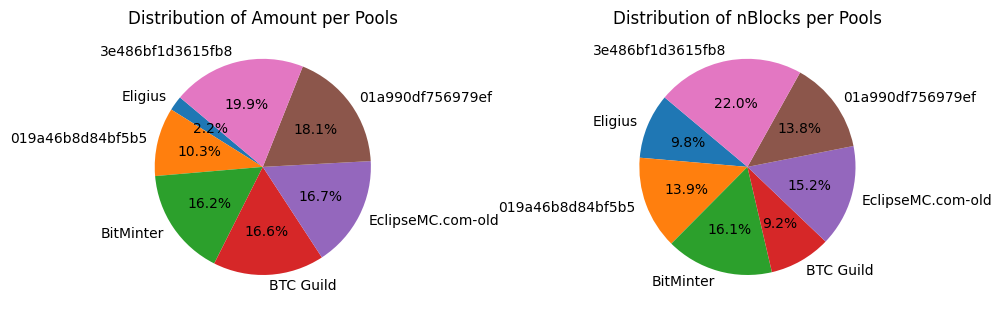

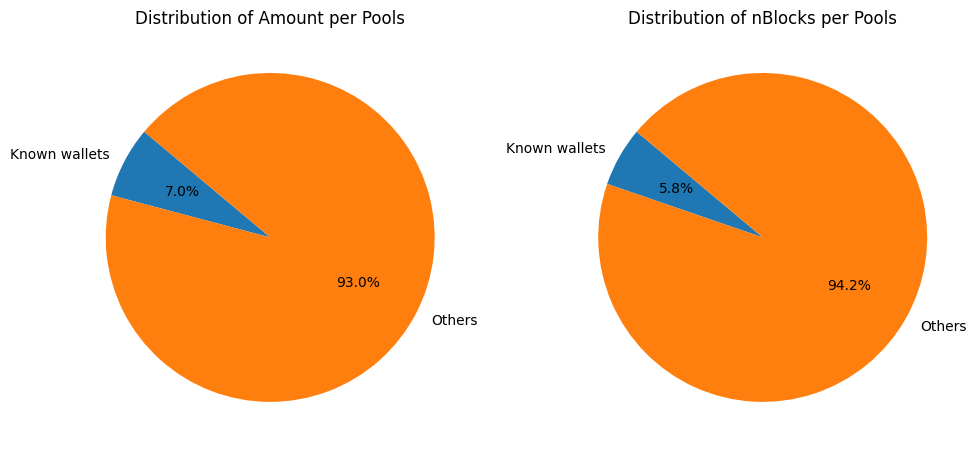

In [240]:
def plot_pie_distr(df):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.pie(df['amount'], labels=df.index, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Amount per Pools')
    
    # Plotting pie chart for nBlocks
    plt.subplot(1, 2, 2)
    plt.pie(df['nBlocks'], labels=df.index, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of nBlocks per Pools')
    
    plt.tight_layout()
    plt.show()

display(pool_blocks)
plot_pie_distr(pool_blocks[pool_blocks.index != 'Others'])
tmp = pool_blocks.reset_index()
# plot_pie_distr(pool_blocks)

def map_wlt (wallet):
    if wallet == 'Others':
        return 'Others'
    return 'Known wallets'

tmp['wallet'] = tmp['wallet'].map(map_wlt)
tmp = tmp.groupby('wallet').sum()

plot_pie_distr(tmp)

In [205]:
def plot_field_bins(FIELD, xrange=None):
    time_bins = pd.Grouper(key='timestamp', freq='2ME')
    plt.figure(figsize=(20, 6))
    COLS = 4
    idx = 1
    
    wallets = pool_blocks.index.to_list()
    ROWS = (len(wallets) + COLS - 1) // COLS 
    
    for wallet in wallets:
        
        df = WALL_COUT.reset_index()[['amount', 'timestamp', 'wallet']]
        df = df[df['wallet'] == wallet]
        
        group = df.groupby(time_bins).agg({
            'amount': 'sum',
            'wallet': 'count',
        })
    
        group.columns = ['amount', 'count']
        
        plt.subplot(ROWS, COLS, idx)
    
        plt.title(f"{wallet} ({FIELD})")
        plt.grid()
        plt.xticks(rotation=45)
    
        plt.plot(group.index, group[FIELD])


        if xrange is not None:
            plt.xlim(xrange[0], xrange[1])
            min_date = group.index.min()
            max_date = group.index.max()
        
            ax = plt.gca()
            ax.axvspan(x_min, min_date, color='red', alpha=0.2)
            ax.axvspan(max_date, x_max, color='red', alpha=0.2)
    
        
        idx = idx + 1

    plt.subplots_adjust(hspace=0.6) 
    plt.show()


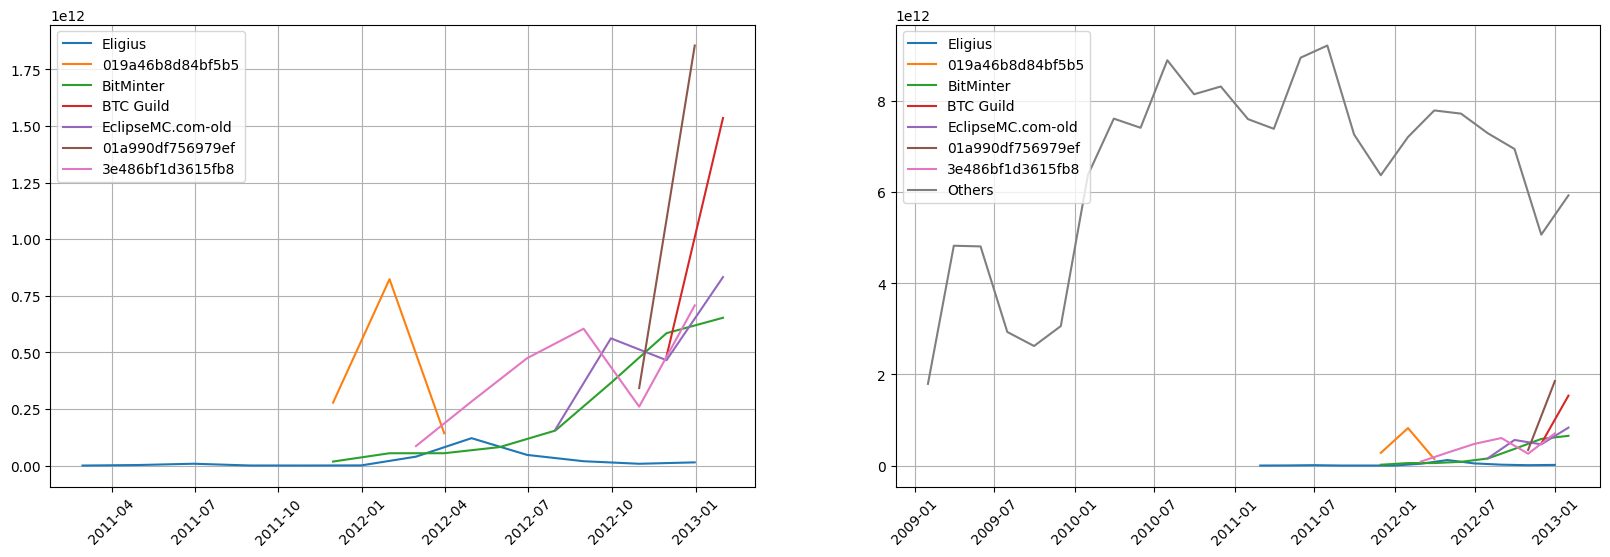

In [202]:
def plot_wallets(wallets, FIELD):
    plt.grid()
    plt.xticks(rotation=45)
    
    time_bins = pd.Grouper(key='timestamp', freq='2ME')
    
    for wallet in wallets:
        df = WALL_COUT.reset_index()[['amount', 'timestamp', 'wallet']]
        df = df[df['wallet'] == wallet]
        
        group = df.groupby(time_bins).agg({
            'amount': 'sum',
            'wallet': 'count',
        })
    
        group.columns = ['amount', 'count']
        plt.plot(group.index, group['amount'], label=wallet)

    plt.legend(loc='upper left')
    # plt.show()

wallets = pool_blocks.index.to_list()
f_no_others = [x for x in wallets if x != 'Others']

plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plot_wallets(f_no_others, 'amount')
plt.subplot(1,2,2)
plot_wallets(wallets, 'amount')

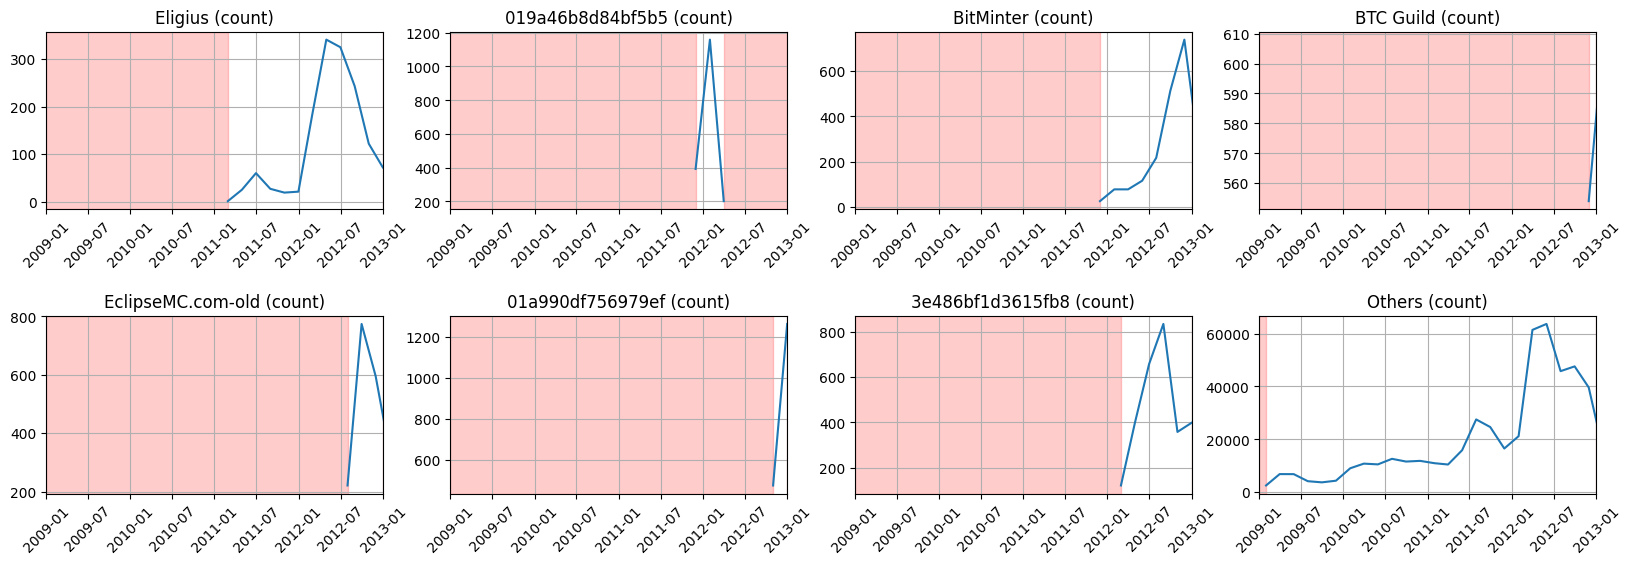

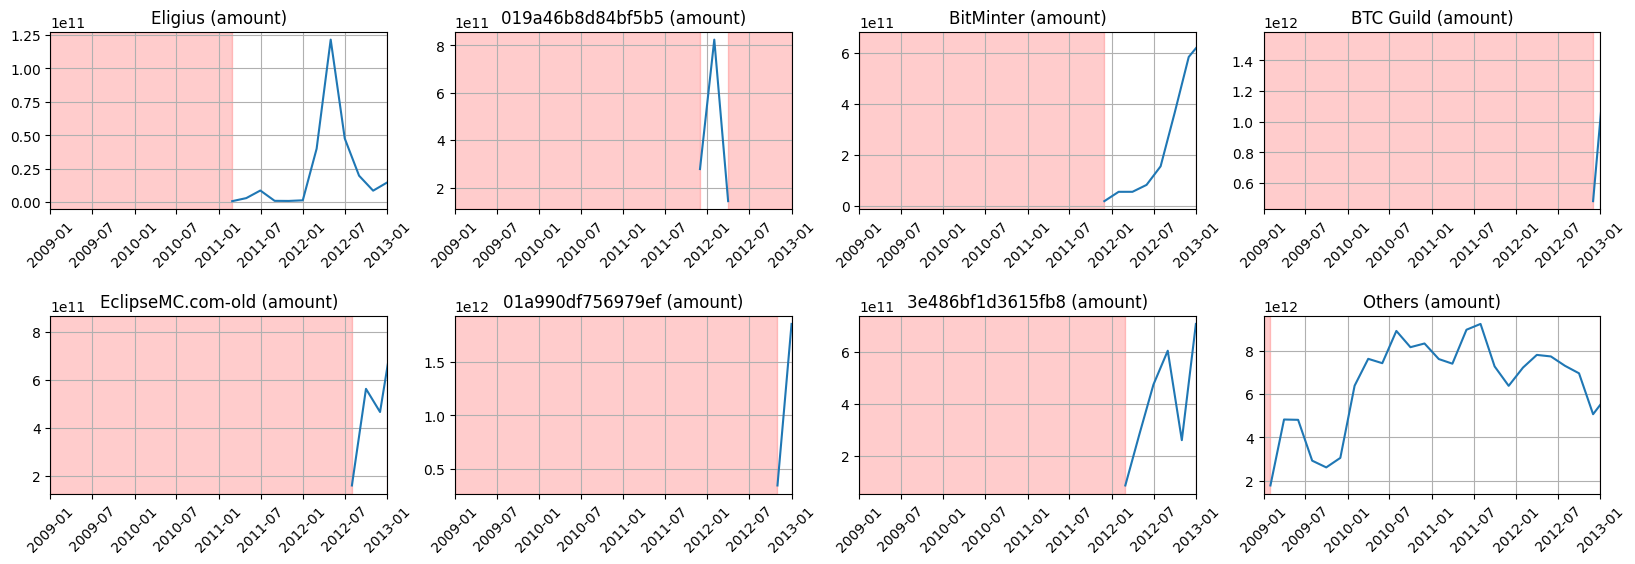

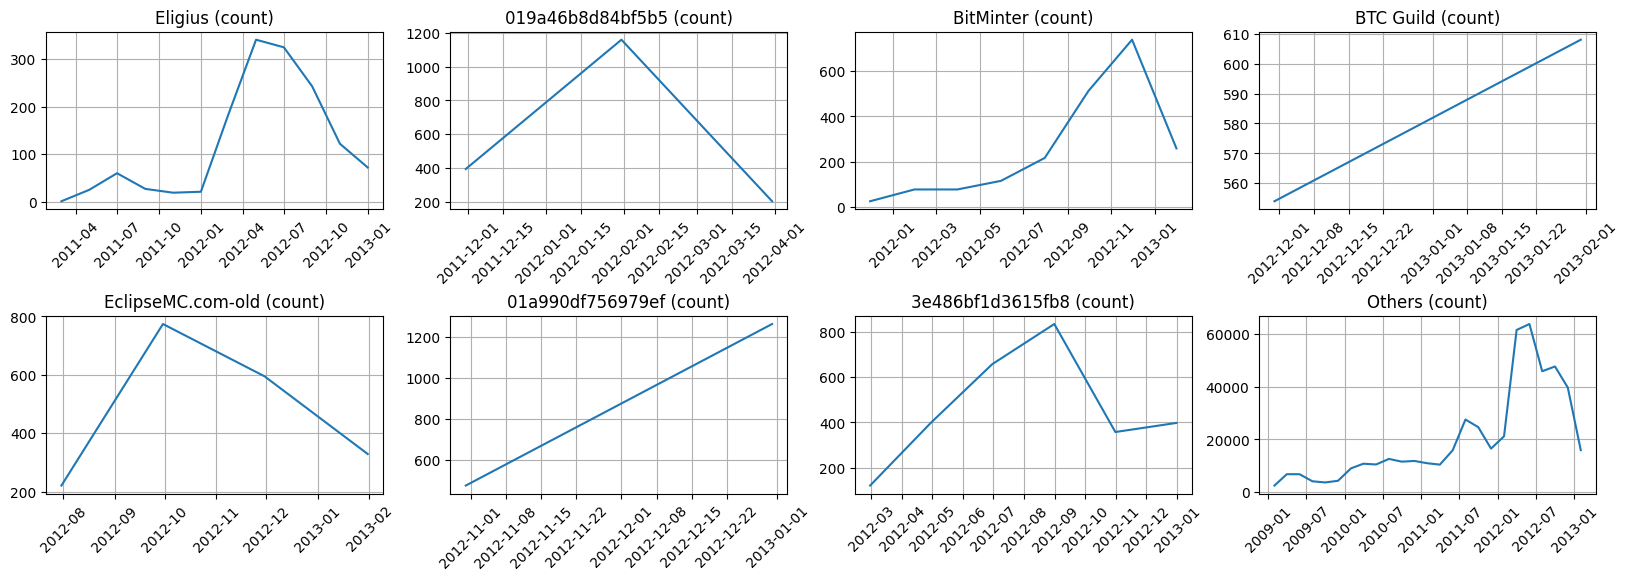

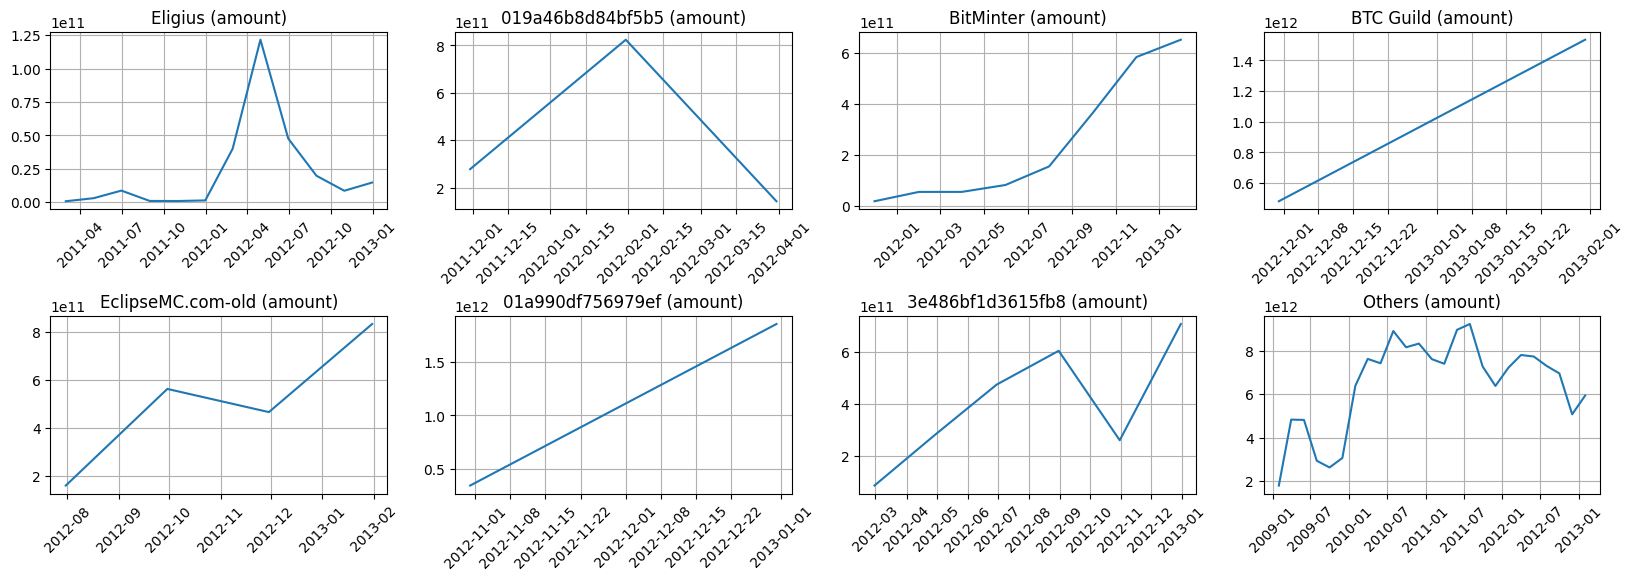

In [206]:
xrange = (pd.Timestamp('2009-01-01'), pd.Timestamp('2013-01-01'))
plot_field_bins('count',  xrange=xrange)
plot_field_bins('amount', xrange=xrange)
plot_field_bins('count')
plot_field_bins('amount')